In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Simulation Data

In [ ]:
# 기본 결과 데이터(시뮬레이션 후 csv 파일)
df = pd.read_csv("test1_ChangeSchedule.csv", parse_dates=['Date/Time'])
df = df.iloc[:,[0,3,4]]
df

In [3]:
### simulation file은 24시간제인데, farmos file은 23:59 이후면 다음날짜로 넘어간다.
# 24를 00으로 대체 후에 timedelta로 하루 이후로 가는 방식 이용
from datetime import datetime, timedelta

def from24tozero(datetime_str, _format):

    '''
    * datetime_str: 변환할 날짜/시간 문자열
    * _format: 형식을 지정하는 포맷 문자열
    '''

    datetime_str = str(datetime_str).strip() # 원본에 양쪽 공백이 있었으므로 공백 제거
    try:
        change_datetime = datetime.strptime(datetime_str, _format) # strptime: 문자열을 datetime 객체로 변환
        return change_datetime.strftime(_format) # strftime: 다시 문자열로 고침
    except ValueError:   # datetime 함수가 감당할 수 없는 날짜 문자열(24시)를 만났을 때.
        adj_datetime = datetime_str.replace('24:','00:')
        change_datetime = datetime.strptime(adj_datetime, _format) + timedelta(days=1) # 변환후에 하루 더하여 다음날의 시간으로
        return change_datetime.strftime(_format)
    
df['Date/Time'] = df['Date/Time'].map(lambda x:from24tozero(x, "%m/%d %H:%M:%S"))

In [4]:
### 필요한 시간만 가져오기
# split date/time
# 날짜 쪼개고 불필요한 열 제거(새로 적용하려는 열이 두개 이므로 맞추는 것)
df_split = df['Date/Time'].str.split(' ', expand=True)  # 공백 나누기
df[['date','time']] = df_split # date와 time 분리

# 원하는 date(6/24~6/30)가 아닌 행 제거
# 날짜 범위
df['date'] = pd.to_datetime(df['date'], format='%m/%d')
start_day = pd.to_datetime('06/24', format='%m/%d')
end_day = pd.to_datetime('06/30', format='%m/%d')

# 범위 내 필터링
filtered_df = df[(df['date'] >= start_day) & (df['date'] <= end_day)]
# 불필요한 컬럼 없애고 인덱스 정렬
filtered_df = filtered_df.drop(columns=['date','time'])
filtered_df.reset_index(inplace=True, drop=True)

# 컬럼 이름 바꾸기
filtered_df.columns = ['date','Temp','Humid']
# 온도와 습도값 반올림
filtered_df['Temp'] = filtered_df['Temp'].round(2)
filtered_df['Humid'] = filtered_df['Humid'].round(2)

In [6]:
# 후에 데이터 병합을 위해 연도 추가, 포맷 바꿈
def add_year(date):
    if len(date.split()) == 2:
        month_day, time = date.split()
        month, day = month_day.split('/')
        return f'2024-{month}-{day} {time}'
    else:
        return date
    
filtered_df['date'] = filtered_df['date'].apply(add_year)
filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d %H:%M:%S')
filtered_df

,date,Temp,Humid
0,2024-06-24 00:00:00,17.69,67.17
1,2024-06-24 01:00:00,17.24,68.66
2,2024-06-24 02:00:00,16.77,70.70
3,2024-06-24 03:00:00,16.44,72.13
4,2024-06-24 04:00:00,16.18,73.24
...,...,...,...
163,2024-06-30 19:00:00,22.23,72.30
164,2024-06-30 20:00:00,20.89,78.30
165,2024-06-30 21:00:00,19.77,83.75
166,2024-06-30 22:00:00,18.75,86.97


## GH_real_value Date(temp, RH)

In [49]:
rv = pd.read_csv('HG_realvalue_temp_humid.csv', parse_dates=['시간'])

rv.set_index('시간',inplace=True)
rv_hour = rv.resample('1H').mean()
rv_hour.reset_index('시간',inplace=True, drop=False)
# 이름 바꾸기
rv_hour.columns = ['date','R_Temp','R_Humid']
# 온도와 습도값 반올림
rv_hour['R_Temp'] = rv_hour['R_Temp'].round(2)
rv_hour['R_Humid'] = rv_hour['R_Humid'].round(2)

In [50]:
rv_hour

,date,R_Temp,R_Humid
0,2024-06-24 00:00:00,19.20,92.63
1,2024-06-24 01:00:00,18.63,93.02
2,2024-06-24 02:00:00,18.14,92.91
3,2024-06-24 03:00:00,18.18,93.98
4,2024-06-24 04:00:00,18.17,94.64
...,...,...,...
163,2024-06-30 19:00:00,20.65,89.15
164,2024-06-30 20:00:00,19.27,90.48
165,2024-06-30 21:00:00,18.83,92.06
166,2024-06-30 22:00:00,18.69,92.48


## Graph and Results

In [9]:
# 두 데이터 프레임 병합
test1_change_schedule = filtered_df.merge(rv_hour, on='date')
test1_change_schedule

,date,Temp,Humid,R_Temp,R_Humid
0,2024-06-24 00:00:00,17.69,67.17,19.20,92.63
1,2024-06-24 01:00:00,17.24,68.66,18.63,93.02
2,2024-06-24 02:00:00,16.77,70.70,18.14,92.91
3,2024-06-24 03:00:00,16.44,72.13,18.18,93.98
4,2024-06-24 04:00:00,16.18,73.24,18.17,94.64
...,...,...,...,...,...
163,2024-06-30 19:00:00,22.23,72.30,20.65,89.15
164,2024-06-30 20:00:00,20.89,78.30,19.27,90.48
165,2024-06-30 21:00:00,19.77,83.75,18.83,92.06
166,2024-06-30 22:00:00,18.75,86.97,18.69,92.48


In [13]:
test1 = test1_change_schedule.set_index('date')

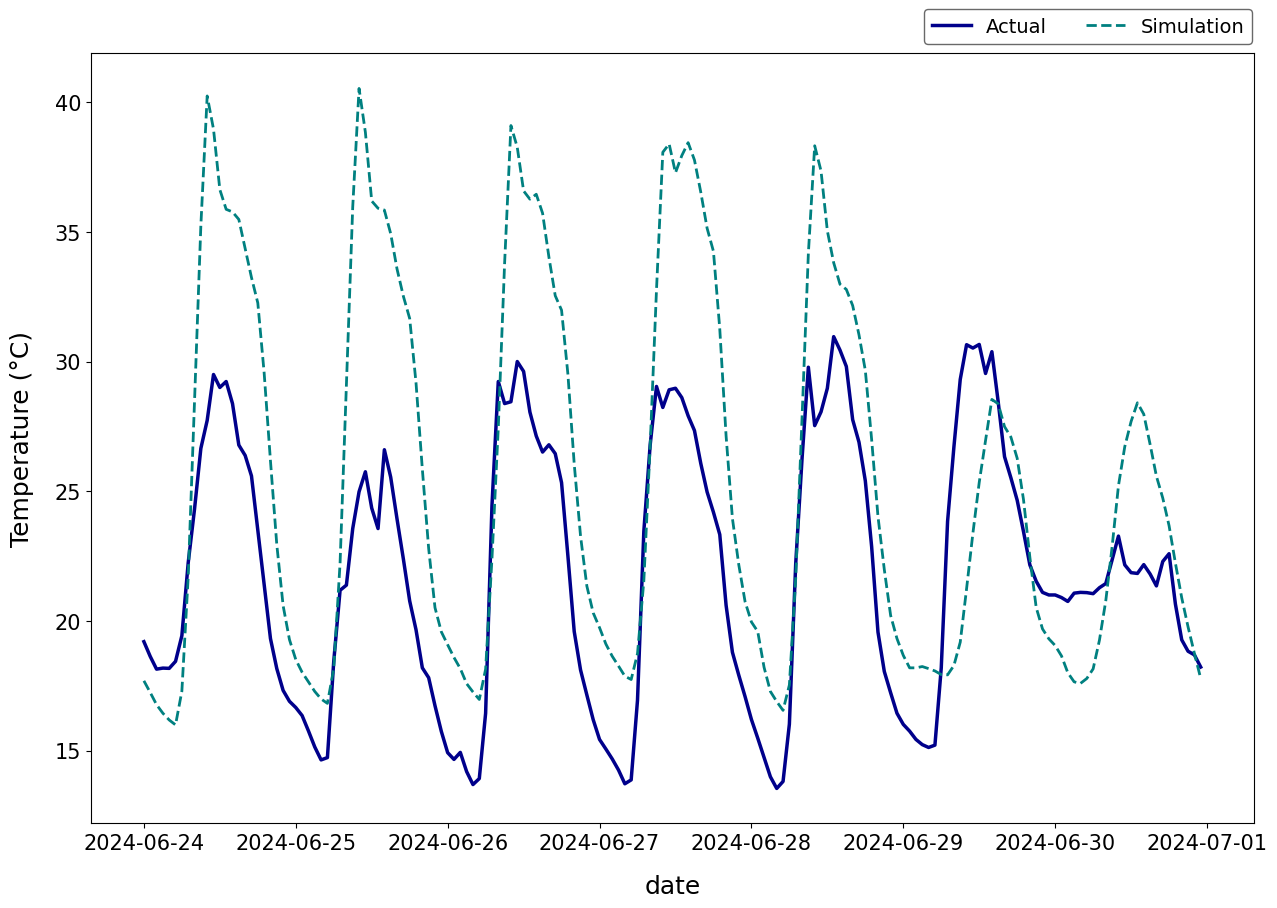

In [21]:
# 온도
plt.figure(figsize=(15, 10))
plt.plot(test1['R_Temp'], label='Actual', linewidth=2.5, color='darkblue') # 선 굵게
plt.plot(test1['Temp'], label='Simulation',linewidth=2.0, color='teal', linestyle='dashed')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylabel('Temperature (°C)', fontdict = {'size':'18'}, labelpad=15)
plt.xlabel('date', fontdict = {'size':'18'}, labelpad=15)


plt.legend(bbox_to_anchor=(1.007, 1.07), prop={'size': 14}, framealpha=1, ncol=3, edgecolor='dimgray', fancybox=True, frameon=True, shadow=False)
plt.show()

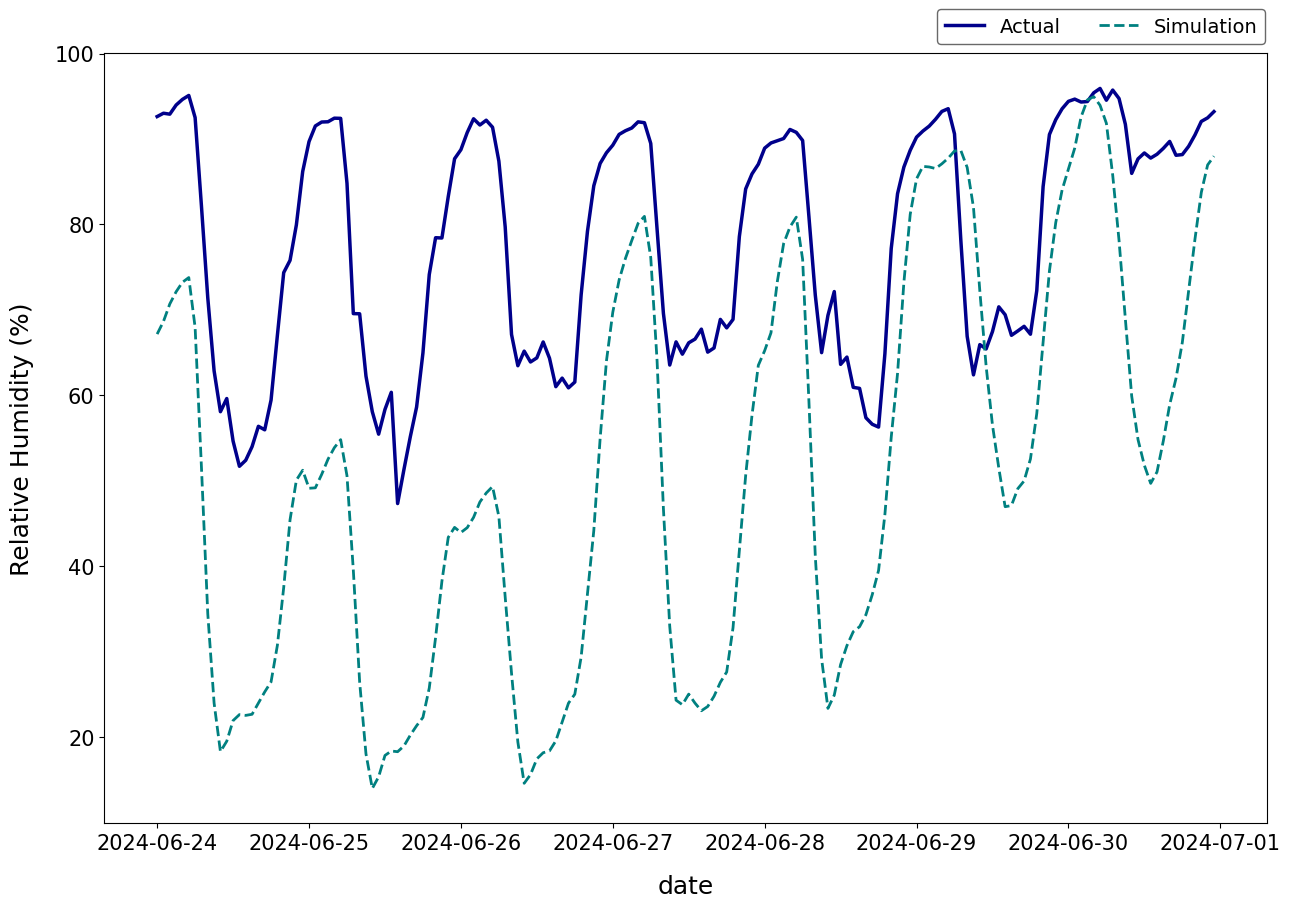

In [22]:
# 습도
plt.figure(figsize=(15, 10))
plt.plot(test1['R_Humid'], label='Actual', linewidth=2.5, color='darkblue') # 선 굵게
plt.plot(test1['Humid'], label='Simulation',linewidth=2.0, color='teal', linestyle='dashed')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylabel('Relative Humidity (%)', fontdict = {'size':'18'}, labelpad=15)
plt.xlabel('date', fontdict = {'size':'18'}, labelpad=15)


plt.legend(bbox_to_anchor=(1.007, 1.07), prop={'size': 14}, framealpha=1, ncol=3, edgecolor='dimgray', fancybox=True, frameon=True, shadow=False)
plt.show()

In [33]:
# Cv(RMSE)
def cv_rmse(true, pred):
    MSE = np.mean((pred - true) ** 2)
    RMSE = np.sqrt(MSE)
    Cv_RMSE = (RMSE / np.mean(true)) * 100

    return Cv_RMSE

print(cv_rmse(test1['R_Temp'], test1['Temp']).round(2))
print(cv_rmse(test1['R_Humid'], test1['Humid']).round(2))

26.86
39.64


## Add: original file result test

In [35]:
# original result data
ori = pd.read_csv('횡계실증팜_EPlus_ori.csv')
ori = ori.iloc[:,[0,3,4]]
ori

,Date/Time,THERMAL ZONE BOTTOM:Zone Air Temperature [C](Hourly),THERMAL ZONE BOTTOM:Zone Air Relative Humidity [%](Hourly)
0,08/21 01:00:00,19.053872,96.911793
1,08/21 02:00:00,18.779955,98.579407
2,08/21 03:00:00,18.570875,99.791616
3,08/21 04:00:00,18.402341,100.000000
4,08/21 05:00:00,18.255955,100.000000
...,...,...,...
6187,06/30 20:00:00,21.124033,76.923366
6188,06/30 21:00:00,19.562042,82.458957
6189,06/30 22:00:00,18.721339,84.895592
6190,06/30 23:00:00,17.802175,86.517550


In [36]:
# 24시간 -> 00으로 대체
ori['Date/Time'] = ori['Date/Time'].map(lambda x:from24tozero(x, "%m/%d %H:%M:%S"))

In [43]:
# 필요한 시간만 가져오기

# date/time 쪼개기
ori_split = ori['Date/Time'].str.split(' ', expand=True)
ori[['date','time']] = ori_split
# 원하는 범위가 아닌 행 제거
ori['date'] = pd.to_datetime(ori['date'], format='%m/%d')
start_ori = pd.to_datetime('06/24', format='%m/%d')
end_ori = pd.to_datetime('06/30', format='%m/%d')

filter_ori = ori[(ori['date'] >= start_ori) & (ori['date'] <= end_ori)]
filter_ori = filter_ori.drop(columns=['date','time'])
filter_ori.reset_index(inplace=True,drop=True)

# column 이름 변경
filter_ori.columns = ['date','Temp','Humid']
# 온도와 습도값 반올림
filter_ori['Temp'] = filter_ori['Temp'].round(2)
filter_ori['Humid'] = filter_ori['Humid'].round(2)

In [48]:
# 시간 포맷 바꾸기
filter_ori['date'] = filter_ori['date'].apply(add_year)
filter_ori['date'] = pd.to_datetime(filter_ori['date'], format="%Y-%m-%d %H:%M:%S")
filter_ori

,date,Temp,Humid
0,2024-06-24 00:00:00,17.77,66.61
1,2024-06-24 01:00:00,17.21,68.18
2,2024-06-24 02:00:00,16.71,69.71
3,2024-06-24 03:00:00,16.39,70.53
4,2024-06-24 04:00:00,16.12,71.00
...,...,...,...
163,2024-06-30 19:00:00,22.43,72.76
164,2024-06-30 20:00:00,21.12,76.92
165,2024-06-30 21:00:00,19.56,82.46
166,2024-06-30 22:00:00,18.72,84.90


In [51]:
# 두 데이터 프레임 병합
test2_original_idf = pd.merge(filter_ori, rv_hour, on='date')
test2_original_idf

,date,Temp,Humid,R_Temp,R_Humid
0,2024-06-24 00:00:00,17.77,66.61,19.20,92.63
1,2024-06-24 01:00:00,17.21,68.18,18.63,93.02
2,2024-06-24 02:00:00,16.71,69.71,18.14,92.91
3,2024-06-24 03:00:00,16.39,70.53,18.18,93.98
4,2024-06-24 04:00:00,16.12,71.00,18.17,94.64
...,...,...,...,...,...
163,2024-06-30 19:00:00,22.43,72.76,20.65,89.15
164,2024-06-30 20:00:00,21.12,76.92,19.27,90.48
165,2024-06-30 21:00:00,19.56,82.46,18.83,92.06
166,2024-06-30 22:00:00,18.72,84.90,18.69,92.48


In [52]:
test2 = test2_original_idf.set_index('date')

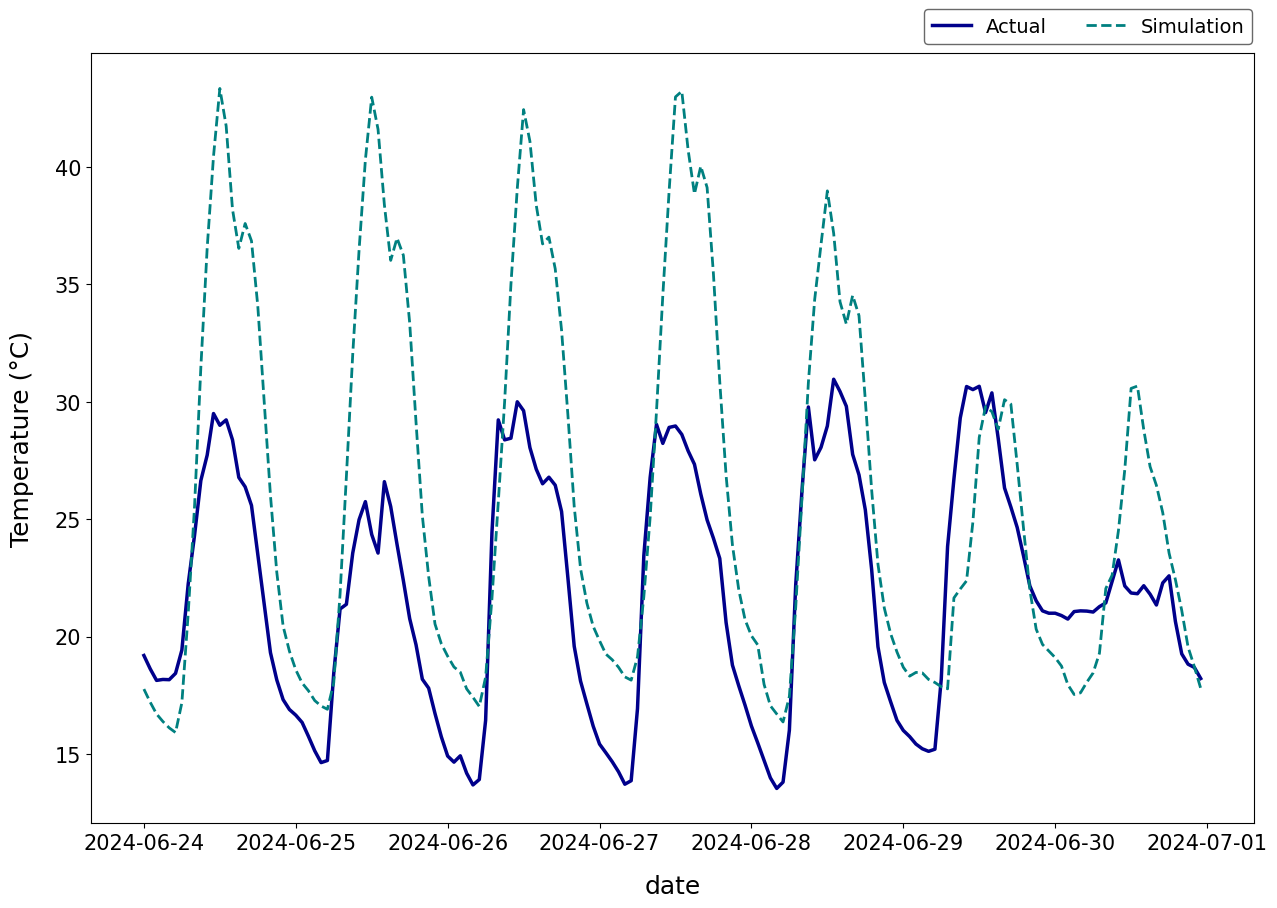

In [53]:
plt.figure(figsize=(15, 10))
plt.plot(test2_original_idf['R_Temp'], label='Actual', linewidth=2.5, color='darkblue') # 선 굵게
plt.plot(test2_original_idf['Temp'], label='Simulation',linewidth=2.0, color='teal', linestyle='dashed')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylabel('Temperature (°C)', fontdict = {'size':'18'}, labelpad=15)
plt.xlabel('date', fontdict = {'size':'18'}, labelpad=15)


plt.legend(bbox_to_anchor=(1.007, 1.07), prop={'size': 14}, framealpha=1, ncol=3, edgecolor='dimgray', fancybox=True, frameon=True, shadow=False)
plt.show()

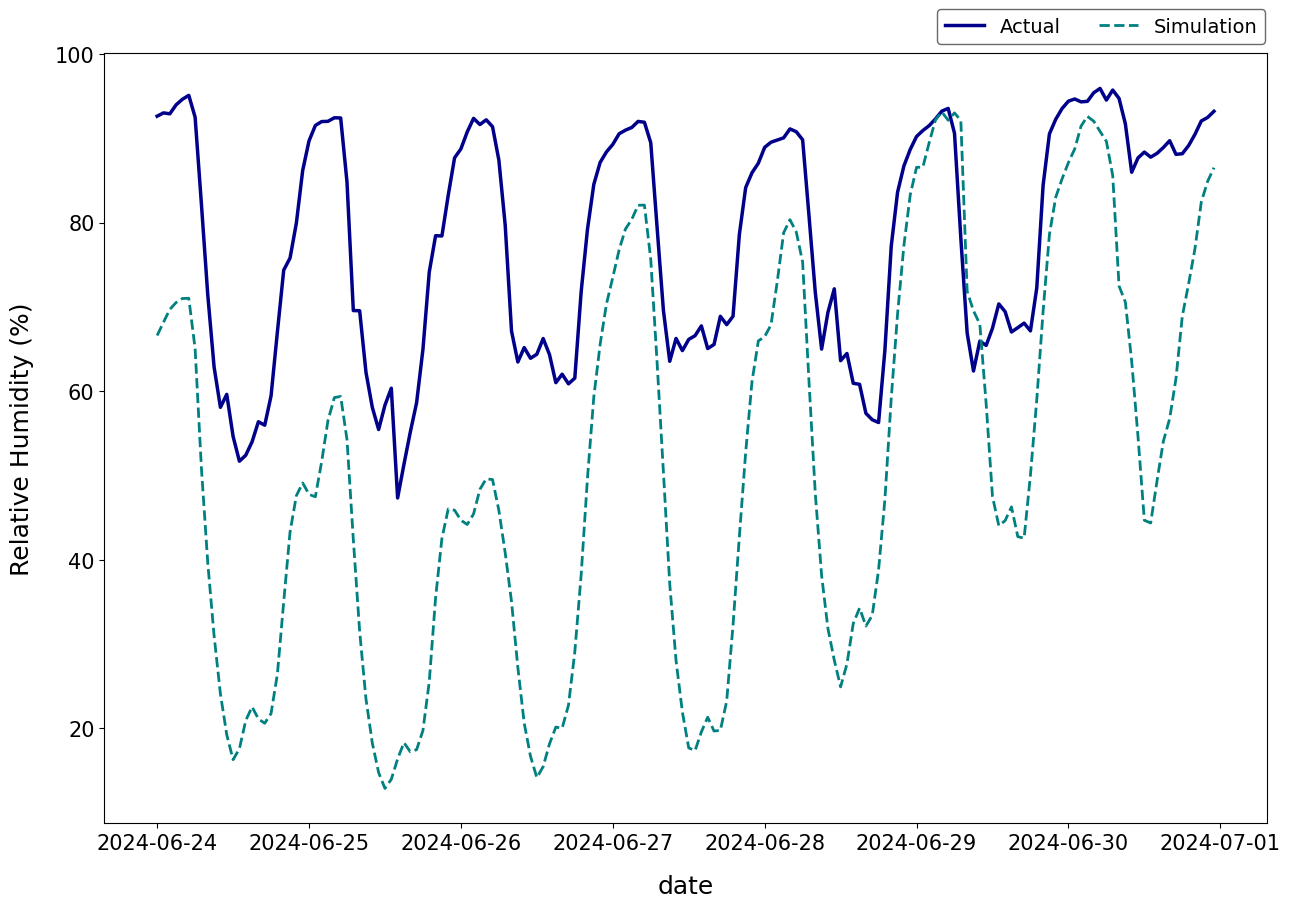

In [54]:
# 습도
plt.figure(figsize=(15, 10))
plt.plot(test2_original_idf['R_Humid'], label='Actual', linewidth=2.5, color='darkblue') # 선 굵게
plt.plot(test2_original_idf['Humid'], label='Simulation',linewidth=2.0, color='teal', linestyle='dashed')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylabel('Relative Humidity (%)', fontdict = {'size':'18'}, labelpad=15)
plt.xlabel('date', fontdict = {'size':'18'}, labelpad=15)


plt.legend(bbox_to_anchor=(1.007, 1.07), prop={'size': 14}, framealpha=1, ncol=3, edgecolor='dimgray', fancybox=True, frameon=True, shadow=False)
plt.show()

In [55]:
print(cv_rmse(test2_original_idf['R_Temp'], test2_original_idf['Temp']).round(2))
print(cv_rmse(test2_original_idf['R_Humid'], test2_original_idf['Humid']).round(2))

30.48
39.21
